<a href="https://colab.research.google.com/github/marianayarce1224/lab_biosenales/blob/main/PROYECTO4/tutorialNeurokit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h4><b>Grupo:</b> 3</h4>
<h4><b>Integrantes:</b> Mariana Álvarez Yarce - Ana María Seguro Acevedo</h4>

<h3><b>Mini-Tutorial: Uso de NeuroKit para el Análisis de Señales ECG</h3></b>

NeuroKit <b>[1]</b> es una biblioteca de Python que permite procesar y analizar señales fisiológicas como ECG. Este tutorial detalla cómo usar este módulo para analizar señales ECG, describiendo las funciones más relevantes y cómo extraer características importantes para modelos predictivos y análisis de datos.

#<h3><b>1. Instalación</h3></b>
Antes de comenzar, asegúrate de instalar NeuroKit y otras dependencias necesarias para el manejo y visualización de datos.

In [11]:
!pip install neurokit2

Importar bibliotecas necesarias para manejo de datos

In [2]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#<h3><b>2. Generar o cargar una señal ECG</h3></b>
Con Neurokit tienes dos opciones: Generar una señal ECG simulada o cargar una señal ECG que desees analizar.

<b>Opción 1. Generar una señal ECG</b>

NeuroKit incluye la función `ecg_simulate` para crear señales ECG simuladas útiles para practicar.

A continuación se muestra un ejemplo de los argumentos que se pueden definir para esta función <b>[1]</b>: `ecg_simulate (duration=10, length=None, sampling_rate=1000, noise=0.01, heart_rate=70, heart_rate_std=1, method='ecgsyn', random_state=None, random_state_distort='spawn')`

- `duration` (int): Duración de registro de la señal en segundos.  
- `sampling_rate` (int): Frecuencia de muestreo en Hz.  
- `length` (int): Número de muestras de la señal.  
- `noise` (float): Nivel de ruido (amplitud del ruido Laplaciano).  
- `heart_rate` (int): Frecuencia cardíaca simulada en latidos por minuto (bpm). Por defecto, es 70 bpm, aunque se esperan fluctuaciones para simular un ritmo cardíaco real.  
- `heart_rate_std` (int): Desviación estándar de la frecuencia cardíaca en bpm.  
- `method` (str): Modelo para generar la señal:  
   - `"simple"`: Basado en wavelets de Daubechies para aproximar un ciclo cardíaco
   - `"ecgsyn"` (por defecto): Modelo descrito por McSharry <i>et al</i> (2003)  
   - `"multileads"`: Genera un DataFrame con 12 derivaciones de ECG.  
- `random_state`: Semilla para el generador de números aleatorios
- `random_state_distort`: Semilla para distorsionar la señal con ruido independiente o dependiente
- `kwargs`: Parámetros adicionales para el algoritmo ECGSYN (como <i>lfhfratio</i>, <i>ti</i>, <i>ai</i>, <i>bi</i>)


Se puede utilizar la función `signal_plot` graficar la señal simulada.

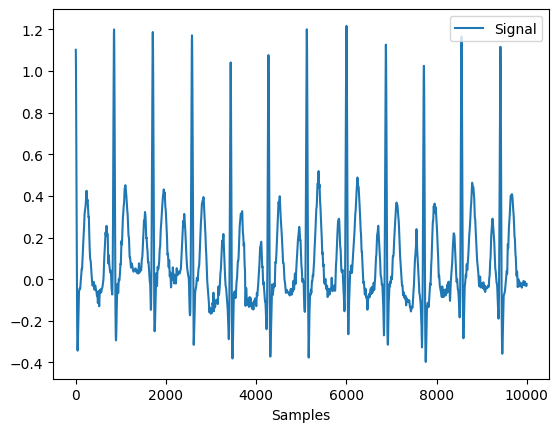

In [3]:
ecg_signal = nk.ecg_simulate(duration=10, sampling_rate=1000, noise=0.05)
nk.signal_plot(ecg_signal, subplots=False)

plt.show()

<b>Opción 2. Cargar una señal ECG</b>

Carga tu archivo <i>csv</i>. En caso de que no esté filtrado o procesado, con Neurokit puedes darle procesamiento a tu señal. Cuando tienes tu propio archivo puedes modificar la función `signal_plot` para ajustar los parámetros.

En este caso tenemos una señal ecg de 12 derivaciones con una frecuencia de muestreo de 500 Hz.

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


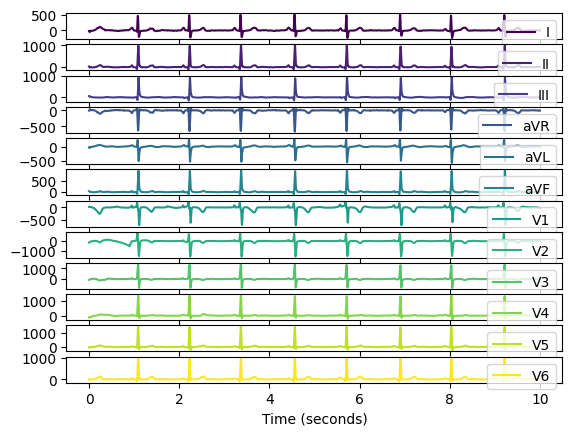

In [9]:
datos = pd.read_csv('/content/drive/MyDrive/ECGDataDenoised/MUSE_20180112_073319_29000.csv', delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
nk.signal_plot(datos, sampling_rate=500, subplots=True)

#<h3><b>3. Procesamiento de la señal</h3></b>
    
La función `ecg_process` simplifica el análisis de señales ECG al realizar múltiples pasos de preprocesamiento y análisis de manera automática. Esta herramienta es ideal para obtener rápidamente información relevante sobre una señal ECG sin necesidad de implementar manualmente cada etapa.

A continuación se muestra un ejemplo de los argumentos que se pueden definir para esta función <b>[1]</b>: `ecg_process(ecg_signal, sampling_rate=1000, method='neurokit)`

- `ecg_signal` (list, np.array, pd.Series): Señal ECG de un solo canal en formato bruto
- `sampling_rate` (int): Frecuencia de muestreo de la señal ECG en Hz (muestras por segundo). El valor predeterminado es 1000 Hz
- `method` (str): Método utilizado para la limpieza de la señal (`ecg_clean()`) y la detección de picos (`ecg_peaks()`). El valor predeterminado es `'neurokit'`. Otros métodos disponibles son: `'pantompkins1985'`, `'hamilton2002'`, `'elgendi2010'`, `'engzeemod2012'`

La función combina varias etapas de análisis que incluyen:

1. <b>Limpieza de la señal (`ecg_clean()`):</b> Filtra la señal para eliminar ruido, interferencias y artefactos, utilizando métodos como filtros de Savitzky-Golay, IIR o FIR. Esto mejora la calidad de la señal para análisis posteriores.

2. <b>Detección de picos R (`ecg_peaks()`):</b> Identifica los picos R en el ECG, que son los puntos clave para calcular parámetros como frecuencia cardíaca y variabilidad de la misma.

3. <b>Cálculo de frecuencia cardíaca (`signal_rate()`):</b>
Calcula la frecuencia cardíaca a partir de los picos R detectados, reportándola en latidos por minuto (BPM).

4. <b>Evaluación de calidad de la señal (`ecg_quality()`):</b>
Analiza la calidad de la señal ECG para identificar si está suficientemente limpia para análisis confiables.

5. <b>Delineación del complejo QRS (`ecg_delineate()`):</b>
Delimita las diferentes ondas y segmentos del ECG (ondas P, QRS, T), permitiendo análisis detallados del ciclo cardíaco.

6. <b>Determinación de fases cardíacas (`ecg_phase()`):</b>
Identifica las fases del ciclo cardíaco (sístole y diástole), lo cual es útil para analizar patrones específicos.

Existen diversos métodos disponibles que puedes variar según tus necesidades:<br><br>

| Método           | Descripción                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| <b>`neurokit`</b>    | Método predeterminado. Utiliza un filtro de Savitzky-Golay y herramientas adicionales para garantizar una señal suave y libre de artefactos. |
| <b>`biosppy`</b>    | Basado en el paquete BioSPPy. Utiliza filtros bandpass para preservar las frecuencias típicas del ECG. |
| <b>`pamtompkins1985`</b> | Implementa el método clásico de Pan-Tompkins para la detección de ondas QRS y limpieza. |
| <b>`hamilton2002`</b>| Método que enfatiza la detección robusta de picos R incluso en presencia de ruido.               |
| <b>`elgendi2010`</b> | Método simple basado en la derivada de la señal y umbrales fijos para la detección de picos.     |



Una vez cargada la señal (como la derivación II del ECG), puedes procesarla así:

In [12]:
signal_ekg = datos['II'].values
signals, info = nk.ecg_process(signal_ekg, sampling_rate=500,method='neurokit')

La función retorna un dataframe. Esta es la información que almacena el dataframe y de la cual puedes extraer las características de tu interés:<br><br>

| <b>Columna</b>                                | <b>Descripción<b>                                                                                        |
|--------------------------------------------|---------------------------------------------------------------------------------------------------------|
|<b>ECG_Raw</b>                                | La señal bruta.                                                                                         |
| <b>ECG_Clean</b>                              | La señal limpia.                                                                                         |
| <b>ECG_Rate</b>                               | Frecuencia cardíaca interpolada entre los picos R.                                                        |
| <b>ECG_Quality</b>                            | La calidad de la señal limpia.                                                                           |
| <b>ECG_R_Peaks</b>                            | Los picos R marcados como “1” en una lista de ceros.                                                     |
| <b>ECG_R_Onsets</b>                           | Los inicios R marcados como “1” en una lista de ceros.                                                   |
| <b>ECG_R_Offsets</b>                          | Los desplazamientos R marcados como “1” en una lista de ceros.                                          |
| <b>ECG_P_Peaks</b>                            | Los picos P marcados como “1” en una lista de ceros.                                                     |
| <b>ECG_P_Onsets</b>                           | Los P-onsets marcados como “1” en una lista de ceros.                                                   |
| <b>ECG_P_Offsets</b>                          | Los desplazamientos P marcados como “1” en una lista de ceros.                                          |
| <b>ECG_Q_Peaks</b>                            | Los picos Q marcados como “1” en una lista de ceros.                                                     |
| <b>ECG_S_Peaks</b>                            | Los picos S marcados como “1” en una lista de ceros.                                                     |
| <b>ECG_T_Peaks</b>                            | Los picos T marcados como “1” en una lista de ceros.                                                     |
| <b>ECG_T_Onsets</b>                           | Los inicios T marcados como “1” en una lista de ceros.                                                   |
| <b>ECG_T_Offsets</b>                          | Los desplazamientos T marcados como “1” en una lista de ceros.                                          |
| <b>ECG_Phase_Atrial</b>                       | Fase cardíaca, marcada por “1” para sístole y “0” para diástole.                                          |
| <b>ECG_Phase_Completion_Atrial</b>            | Finalización de la fase cardíaca (auricular), expresada en porcentaje (de 0 a 1), que representa el estadio de la fase cardíaca actual. |
| <b>ECG_Phase_Completion_Ventricular</b>       | Finalización de la fase cardíaca (ventricular), expresada en porcentaje (de 0 a 1), que representa el estadio de la fase cardíaca actual. |
| <b>rpeaks</b>                        | Un diccionario que contiene las muestras en las que se producen los picos R, accesible con la clave "ECG_R_Peaks", así como la frecuencia de muestreo de las señales. |

In [13]:
df = pd.json_normalize(info)
df_info = df.T
df_info

,0
method_peaks,neurokit
method_fixpeaks,None
ECG_R_Peaks,"[547, 1116, 1685, 2283, 2858, 3454, 4018, 4609]"
ECG_R_Peaks_Uncorrected,"[547, 1116, 1685, 2283, 2858, 3454, 4018, 4609]"
ECG_fixpeaks_ectopic,[]
ECG_fixpeaks_missed,[]
ECG_fixpeaks_extra,[]
ECG_fixpeaks_longshort,[]
ECG_fixpeaks_method,kubios
ECG_fixpeaks_rr,"[1.1605714285714286, 1.138, 1.138, 1.196, 1.15..."


#<h3><b>4. Visualización</h3></b>

Con la función `ecg_plot()` puedes realizar la visualización de la señal y otras características resultantes de la función `ecg_process()`.

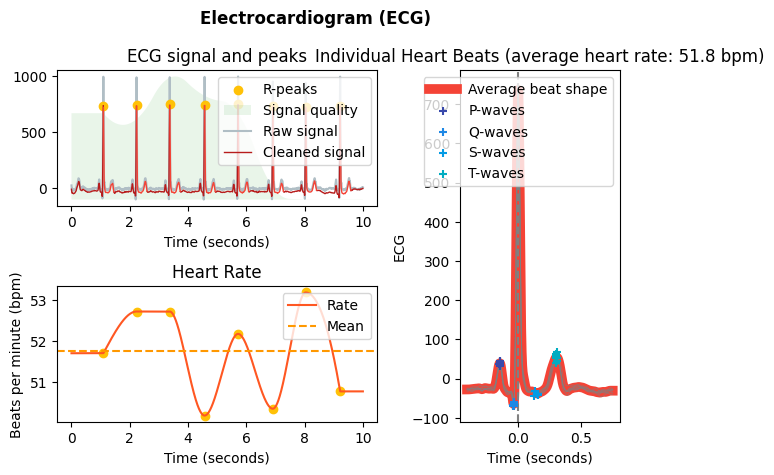

In [16]:
nk.ecg_plot(signals, info)
plt.tight_layout()

#<h3><b>5. Extracción de características del ECG</h3></b>

El procesamiento de ECG con `nk.ecg_process ` proporciona un conjunto de características útiles como frecuencia cardíaca (ECG_Rate), calidad de la señal (ECG_Quality) y eventos cardíacos detectados (ECG_R_Peaks, ECG_P_Peaks, etc).

Puedes graficar cualquier columna del resultante, como ECG_T_Peaks, ECG_P_Peaks, etc. Solo necesitas usar los índices donde estos eventos son "1".

El método `nk.events_plot ` sirve para visualizar cualquier evento detectado, como los picos R o cualquier otro marcador de la señal ECG.

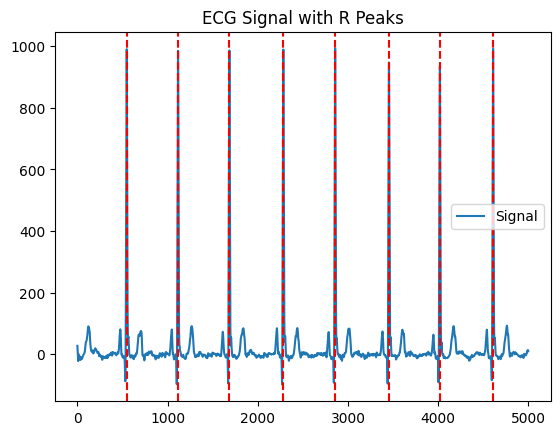

In [17]:
rpeaks = info['ECG_R_Peaks']  # Extraer las posiciones de los picos R
nk.events_plot(rpeaks, signal_ekg)
plt.title("ECG Signal with R Peaks")
plt.show()

De igual forma puedes explorar con cualquier evento que desees graficar y analizar.

#<h3><b>6. Análisis de la forma de onda del ECG</h3></b>

Si estás interesado en realizar un análisis más detallado sobre la forma de la onda del ECG, puedes utilizar `ecg_delineate()`, función que no solo detecta los picos sino que también segmenta las diferentes fases del ciclo cardíaco.

La función `ecg_delineate()` identifica y separa las siguientes componentes del ciclo cardiaco:
- Onda P
- Complejo QRS
- Onda T

El análisis de la forma de la onda te permitirá identificar patrones específicos relacionados con la salud cardíaca y posibles anomalías en la temporalidad de estos componentes.

La función `nk.ecg_delineate` con los parámetros definidos como `show=True` y `show_type='peaks'` se utiliza para visualizar un solo ciclo cardíaco del ECG junto con los picos de las ondas detectados (P, Q, R, S, T).

(      ECG_P_Peaks  ECG_Q_Peaks  ECG_S_Peaks  ECG_T_Peaks  ECG_P_Onsets  \
 0               0            0            0            0             0   
 1               0            0            0            0             0   
 2               0            0            0            0             0   
 3               0            0            0            0             0   
 4               0            0            0            0             0   
 ...           ...          ...          ...          ...           ...   
 4995            0            0            0            0             0   
 4996            0            0            0            0             0   
 4997            0            0            0            0             0   
 4998            0            0            0            0             0   
 4999            0            0            0            0             0   
 
       ECG_T_Offsets  
 0                 0  
 1                 0  
 2                 0  
 3    

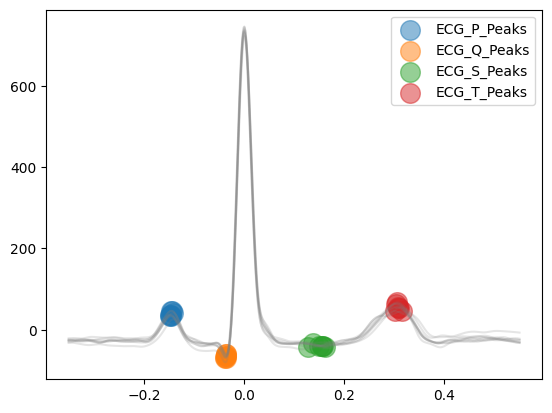

In [18]:
clean_signal = signals["ECG_Clean"]
delineated = nk.ecg_delineate(clean_signal, sampling_rate=500, method="peak")

nk.ecg_delineate(clean_signal,rpeaks, sampling_rate=500,  method="peak", show=True,show_type='peaks')

Esta función retorna la siguiente información:

- La señal ECG original con las posiciones de las ondas delineadas (P, QRS, T), representadas como eventos en la señal.
- Un diccionario que contiene las posiciones de los eventos de cada onda en la señal de ECG. Estos eventos incluyen, por ejemplo:
> <b>ECG_P_Onsets:</b> el inicio de la onda P<br>
<b>ECG_P_Peaks:</b> el pico de la onda P<br>
<b>ECG_T_Onsets:</b> el inicio de la onda T<br>
<b>ECG_T_Peaks:</b> el pico de la onda T<br>
<b>ECG_R_Peaks:</b> los picos R (ya detectados previamente)

In [19]:
signals2, waves = nk.ecg_delineate(clean_signal, rpeaks, sampling_rate=1000)
print(waves)

{'ECG_P_Peaks': [396, 987, 1503, 2125, 2745, 3224, 3889, 4428], 'ECG_P_Onsets': [383, 972, 1486, 2107, 2720, 3208, 3866, 4393], 'ECG_P_Offsets': [407, 1012, 1539, 2150, 2757, 3237, 3916, 4452], 'ECG_Q_Peaks': [528, 1098, 1667, 2265, 2839, 3436, 4000, nan], 'ECG_R_Onsets': [514, 1086, 1655, 2252, 2827, 3421, 3988, nan], 'ECG_R_Offsets': [601, 1170, 1738, 2327, 2907, 3514, 4070, 4651], 'ECG_S_Peaks': [624, 1194, 1762, 2346, 2932, 3534, 4086, nan], 'ECG_T_Peaks': [696, 1266, 1834, 2434, 3008, 3605, 4169, 4761], 'ECG_T_Onsets': [688, 1236, 1795, 2398, 2976, 3575, 4131, 4722], 'ECG_T_Offsets': [726, 1297, 1867, 2469, 3041, 3637, 4206, 4793]}


Finalmente con `nk.events_plot()`, se grafican los eventos de la onda P (su inicio y su pico) sobre la señal de ECG para ayudar a visualizar cómo se distribuyen estos eventos a lo largo de la señal.

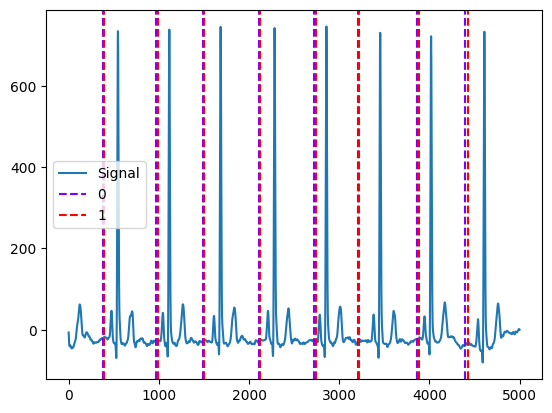

In [20]:
nk.events_plot([waves["ECG_P_Onsets"], waves["ECG_P_Peaks"]], clean_signal)

La función `nk.ecg_phase()` se utiliza para obtener las fases cardíacas a partir de una señal ECG. Esta función tiene los siguientes parámetros clave:

- `clean_signal`: Es la señal ECG que ya ha sido procesada (como en tu caso, clean_signal), donde se espera que esté libre de artefactos o ruido
- `rpeaks`: Son los picos R detectados en la señal ECG. Los picos R son importantes porque marcan el final de la onda P y el comienzo de la onda QRS, lo que ayuda a identificar las fases del ciclo cardíaco
- `delineate_info`: Es la información sobre las ondas detectadas en la señal, como la onda P, el complejo QRS y la onda T. Esto permite que la función `ecg_phase()` determine las fases más específicas de cada ciclo cardíaco
- `sampling_rate`: La frecuencia de muestreo de la señal (en este caso, 500 Hz)

El objetivo principal de la función es identificar y etiquetar las fases del ciclo cardíaco, específicamente las fases auricular y ventricular, a lo largo de la señal ECG.

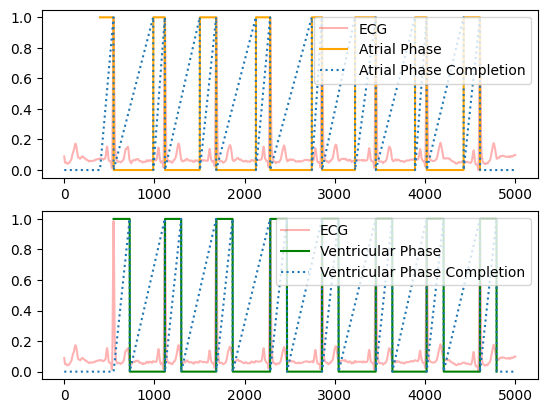

In [27]:
cardiac_phase = nk.ecg_phase(clean_signal, rpeaks=rpeaks, delineate_info=waves, sampling_rate=500)
_, ax = plt.subplots(nrows=2)

ax[0].plot(nk.rescale(clean_signal), label="ECG", color="red", alpha=0.3)
ax[0].plot(cardiac_phase["ECG_Phase_Atrial"], label="Atrial Phase", color="orange")
ax[0].plot(cardiac_phase["ECG_Phase_Completion_Atrial"], label="Atrial Phase Completion", linestyle="dotted")
ax[0].legend(loc="upper right")

ax[1].plot(nk.rescale(clean_signal), label="ECG", color="red", alpha=0.3)
ax[1].plot(cardiac_phase["ECG_Phase_Ventricular"], label="Ventricular Phase", color="green")
ax[1].plot(cardiac_phase["ECG_Phase_Completion_Ventricular"], label="Ventricular Phase Completion", linestyle="dotted")
ax[1].legend(loc="upper right")

La función `ecg_rate()` Calcula la tasa de señal (por minuto) a partir de una serie de picos. Es una función general que funciona para cualquier serie de picos (es decir, no es específica de señales ECG pero puede usarse). El período es el tiempo entre los picos.

array([51.69867061, 51.69867061, 51.69867061, ..., 50.76142132,
       50.76142132, 50.76142132])

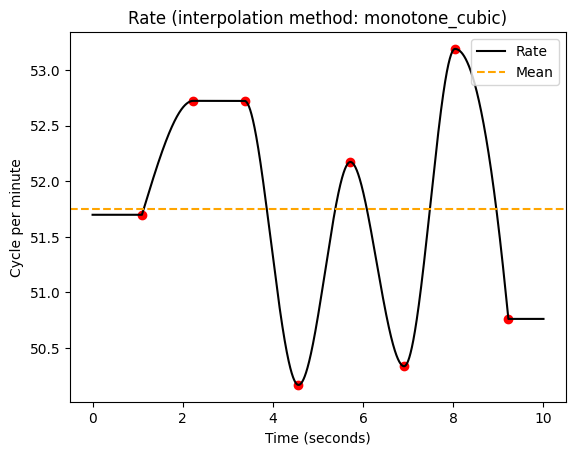

In [22]:
heart_rate = nk.ecg_rate(rpeaks, sampling_rate=500, desired_length=len(clean_signal), show=True)
heart_rate

De acuerdo a los datos que son extraídos con Neurokit, se pueden construir otras métricas que son importantes para el análisis de señales ECG, como en este caso el promedio de la frecuencia cardíaca.

In [23]:
average_rate = np.mean(heart_rate)
print(f"Promedio de la frecuencia cardíaca: {average_rate:.2f} ciclos por minuto")

Promedio de la frecuencia cardíaca: 51.75 ciclos por minuto


#<b>Referencias</b>


<b>[1]:</b> Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H., Schölzel, C., & Chen, S. A. (2021). NeuroKit2: A Python toolbox for neurophysiological signal processing. <i>Behavior Research Methods</i>, 53(4), 1689-1696. https://doi.org/10.3758/s13428-020-01516-y